In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("classification_first")\
        .getOrCreate()
spark
    

In [43]:
from preprocssing import preprocess_csv

[autoreload of preprocssing failed: Traceback (most recent call last):
  File "/home/hasan/anaconda3/envs/spark_env_new/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/hasan/anaconda3/envs/spark_env_new/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/hasan/anaconda3/envs/spark_env_new/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/home/hasan/anaconda3/envs/spark_env_new/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 839, in exec_module
  File "<frozen importlib._bootstrap_external>", line 976, in get_code
  File "<frozen importlib._bootstrap_external>", line 906, in source_to_code
  File "<frozen importlib._bootstrap>

printing dataframe
 =====
   Case_No  A1  A2  A3  A4  A5  A6  A7  A8  A9  A10  Age_Mons  Qchat-10-Score  \
0        1   0   0   0   0   0   0   1   1   0    1        28               3   
1        2   1   1   0   0   0   1   1   0   0    0        36               4   

  Sex       Ethnicity Jaundice Family_mem_with_ASD Who completed the test  \
0   f  middle eastern      yes                  no          family member   
1   m  White European      yes                  no          family member   

  Class/ASD Traits   
0                No  
1               Yes  
number of rows 1054
removing nan from columns
number of rows 1054
 printing dataframe schema 

root
 |-- Case_No: integer (nullable = true)
 |-- A1: integer (nullable = true)
 |-- A2: integer (nullable = true)
 |-- A3: integer (nullable = true)
 |-- A4: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A6: integer (nullable = true)
 |-- A7: integer (nullable = true)
 |-- A8: integer (nullable = true)
 |-- A9: int

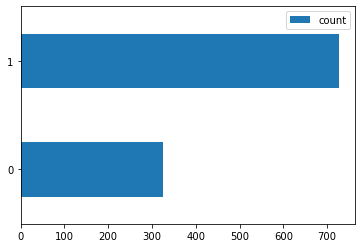

In [35]:
df_test,cont_vars, cat_vars = preprocess_csv(
    csv_file_name='Toddler Autism dataset July 2018.csv',
    dependent_var='Class/ASD Traits ',
    treat_outlier=True,
    train_split=0.7,
    test_split=0.3
)

In [36]:
df_test.columns

['Case_No',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'Age_Mons',
 'Qchat-10-Score',
 'Sex',
 'Ethnicity',
 'Jaundice',
 'Family_mem_with_ASD',
 'Who completed the test',
 'Class/ASD Traits ',
 'Who completed the test_num']

In [37]:
cont_vars

['Case_No',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'Age_Mons',
 'Qchat-10-Score']

In [38]:
cat_vars

['Sex_num',
 'Ethnicity_num',
 'Jaundice_num',
 'Family_mem_with_ASD_num',
 'Who completed the test_num']

In [39]:
df_test.columns

['Case_No',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'Age_Mons',
 'Qchat-10-Score',
 'Sex',
 'Ethnicity',
 'Jaundice',
 'Family_mem_with_ASD',
 'Who completed the test',
 'Class/ASD Traits ',
 'Who completed the test_num']

In [42]:
%%writefile preprocssing.py

from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("classification_first")\
        .getOrCreate()
spark
    

from pyspark.sql.functions import *
from pyspark.sql.types import (IntegerType,
                               FloatType,
                               StringType)
from pyspark.ml.feature import (StringIndexer,
                                VectorAssembler,
                                MinMaxScaler,
                                StandardScaler)

from pyspark.ml.classification import (RandomForestClassifier,
                                       GBTClassifier)

from pyspark.ml.evaluation import (BinaryClassificationEvaluator,
                                   MulticlassClassificationEvaluator)

from pyspark.ml.tuning import (CrossValidator,
                               ParamGridBuilder)

def convert_cat_type(
    df,
    col_name:str):

    indexed = StringIndexer(
        inputCol=col_name,
        outputCol=f'{col_name}_num'
    )
    df_in = indexed.fit(df).transform(df)

    return df_in



def cont_cat_split(df, independent_vars):

    cont_columns = []
    cat_columns = []

    for i in independent_vars:
        if str(df.schema[i].dataType) == 'StringType':

            new_column_name = f'{i}_num'
            df = convert_cat_type(
                df,
                col_name=i)

            cat_columns.append(new_column_name)
        else:
            cont_columns.append(i)

    return df, cont_columns, cat_columns


def percentile_from_continuous_var(
    df,
    continuous_columns):

    d = { }

    for i in continuous_columns:
        d[i] = df.approxQuantile(i, [0.01, 0.99], 0.01)

    return d

def treat_outliers(
    indexed,
    numeric_inputs,
    d):

    for col in numeric_inputs:
        skew = indexed.agg(
            skewness(
                indexed[col])
        ).collect()
        skew = skew[0][0]
        if skew > 1:
            indexed = indexed.withColumn(
                col,
                log(when(df[col] < d[col][0],d[col][0])\
                    .when(indexed[col] >d[col][1], d[col][1])\
                    .otherwise(indexed[col]) +1).alias(col)
            )

            print(f'{col} has been treated for positive right skewness')
        elif skew < -1:
            indexed = indexed.withColumn(
                col,
                exp(
                    when(df[col] < d[col][0], d[col][0])\
                   .when(df[col] > d[col][1], d[col][1])\
                   .otherwise(df[col])
                   ).alias(col)
                   )
            print(f'{col} has been treated for negative (left) skewness')

    return indexed


def preprocess_csv(
    csv_file_name:str,
    dependent_var:str,
    treat_outlier=False,
    train_split=0.7,
    test_split=0.3):

    df = spark.read.csv(
        csv_file_name,
        header=True,
        inferSchema=True)
    
    print('printing dataframe\n =====')
    print(df.limit(2).toPandas())

    print(f'number of rows {df.count()}')

    print(f'removing nan from columns')
    df = df.na.drop()
    print(f'number of rows {df.count()}')

    print(f' printing dataframe schema \n')
    print(df.printSchema())

    print(
        'This is a classification problem, showing distribution of dependent variable\n')
    
    dependent_var_distribution = df.groupBy(dependent_var).count().toPandas()

    print(f' === printing distribution of output \n ====')

    print(dependent_var_distribution)

    dependent_var_distribution.plot.barh()

    independent_vars = df.columns
    independent_vars.remove(dependent_var)

    print(f'\n == independent variables are {independent_vars} == \n')


    print(f' extracting continuous and categorical variables \n')

    print(f' ======  ')

    df, cont_vars, cat_vars = cont_cat_split(
        df,independent_vars)

    df_indexed = df

    print(df_indexed.columns)

    print(f' continuous variables are ===  {cont_vars} === \n categorical variables == {cat_vars}')

    print(f' percentile of continuous columns extracting in a dictionary')

    dict_ = percentile_from_continuous_var(
    df_indexed,
        cont_vars)

    if treat_outlier:

        print(' Treating outliers === \n')

        df_indexed = treat_outliers(
            df_indexed,
            cont_vars,
                dict_)

    else: print(f'== outliers is not treated === ')

    features_list = cont_vars + cat_vars

    print(f' =====so now columns are \n ===========')

    print(df_indexed.columns)

    print(f'\n')
    print(f' ===================== features list ============\n')
    print(f'{features_list}')

    assembler = VectorAssembler(
        inputCols=features_list,
        outputCol='features'
    )
    df_new = assembler.transform(
            df_indexed).select('features', 'label')

    min_=0
    max_=1000

    print(f' scaling features to Minmax\n minimum is = {min_} and maximum is  { max_}')
    scaler = MinMaxScaler(
        inputCol='features',
        outputCol='scaledFeatures',
        min=min_,
        max=max_
        )

    scaled_data = scaler.fit(df_new).transform(df_new)

    final_data = scaled_data.select(
        'label','scaledFeatures'
        )

    print(final_data.show(5))

    # Rename to default value
    final_data = final_data.withColumnRenamed(
        'scaledFeatures',
        'features'
        )

    print(f' printing again the reamed version of data\n')
    print(final_data.show(5))

    print('splitting the data to test and training set')

    df_train, df_test = final_data.randomSplit(
        [train_split, test_split]
    )
    return df_train, df_test

Overwriting preprocssing.py


In [46]:
df = spark.read.csv(
    'Toddler Autism dataset July 2018.csv',
    header=True,
    inferSchema=True)
df.show(5)



+-------+---+---+---+---+---+---+---+---+---+---+--------+--------------+---+--------------+--------+-------------------+----------------------+-----------------+
|Case_No| A1| A2| A3| A4| A5| A6| A7| A8| A9|A10|Age_Mons|Qchat-10-Score|Sex|     Ethnicity|Jaundice|Family_mem_with_ASD|Who completed the test|Class/ASD Traits |
+-------+---+---+---+---+---+---+---+---+---+---+--------+--------------+---+--------------+--------+-------------------+----------------------+-----------------+
|      1|  0|  0|  0|  0|  0|  0|  1|  1|  0|  1|      28|             3|  f|middle eastern|     yes|                 no|         family member|               No|
|      2|  1|  1|  0|  0|  0|  1|  1|  0|  0|  0|      36|             4|  m|White European|     yes|                 no|         family member|              Yes|
|      3|  1|  0|  0|  0|  0|  0|  1|  1|  0|  1|      36|             4|  m|middle eastern|     yes|                 no|         family member|              Yes|
|      4|  1|  1|  1| 

In [47]:
df.printSchema()

root
 |-- Case_No: integer (nullable = true)
 |-- A1: integer (nullable = true)
 |-- A2: integer (nullable = true)
 |-- A3: integer (nullable = true)
 |-- A4: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A6: integer (nullable = true)
 |-- A7: integer (nullable = true)
 |-- A8: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- A10: integer (nullable = true)
 |-- Age_Mons: integer (nullable = true)
 |-- Qchat-10-Score: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Jaundice: string (nullable = true)
 |-- Family_mem_with_ASD: string (nullable = true)
 |-- Who completed the test: string (nullable = true)
 |-- Class/ASD Traits : string (nullable = true)



In [48]:
print(f'Data Frame row number before na removal {df.count()}')
df = df.na.drop()

print(f'Data Frame row number after na removal {df.count()}')

Data Frame row number before na removal 1054
Data Frame row number after na removal 1054


In [49]:
dependent_variable = 'Class/ASD Traits '
count_df = df.groupBy(dependent_variable).count().toPandas()
count_df

,Class/ASD Traits,count
0,No,326
1,Yes,728


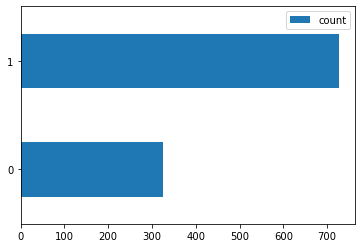

In [29]:
count_df.plot.barh();

In [30]:
independent_variable = df.columns
independent_variable.remove(dependent_variable)

In [34]:
dependent_variable

'Class/ASD Traits '

In [50]:
df.printSchema()

root
 |-- Case_No: integer (nullable = true)
 |-- A1: integer (nullable = true)
 |-- A2: integer (nullable = true)
 |-- A3: integer (nullable = true)
 |-- A4: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A6: integer (nullable = true)
 |-- A7: integer (nullable = true)
 |-- A8: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- A10: integer (nullable = true)
 |-- Age_Mons: integer (nullable = true)
 |-- Qchat-10-Score: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Jaundice: string (nullable = true)
 |-- Family_mem_with_ASD: string (nullable = true)
 |-- Who completed the test: string (nullable = true)
 |-- Class/ASD Traits : string (nullable = true)



In [53]:
indexer = StringIndexer(
    inputCol=dependent_variable,
    outputCol='label'
)
df = indexer.fit(df).transform(df)
df.show(5)

+-------+---+---+---+---+---+---+---+---+---+---+--------+--------------+---+--------------+--------+-------------------+----------------------+-----------------+-----+
|Case_No| A1| A2| A3| A4| A5| A6| A7| A8| A9|A10|Age_Mons|Qchat-10-Score|Sex|     Ethnicity|Jaundice|Family_mem_with_ASD|Who completed the test|Class/ASD Traits |label|
+-------+---+---+---+---+---+---+---+---+---+---+--------+--------------+---+--------------+--------+-------------------+----------------------+-----------------+-----+
|      1|  0|  0|  0|  0|  0|  0|  1|  1|  0|  1|      28|             3|  f|middle eastern|     yes|                 no|         family member|               No|  1.0|
|      2|  1|  1|  0|  0|  0|  1|  1|  0|  0|  0|      36|             4|  m|White European|     yes|                 no|         family member|              Yes|  0.0|
|      3|  1|  0|  0|  0|  0|  0|  1|  1|  0|  1|      36|             4|  m|middle eastern|     yes|                 no|         family member|           

In [61]:
df.printSchema()

root
 |-- Case_No: integer (nullable = true)
 |-- A1: integer (nullable = true)
 |-- A2: integer (nullable = true)
 |-- A3: integer (nullable = true)
 |-- A4: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A6: integer (nullable = true)
 |-- A7: integer (nullable = true)
 |-- A8: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- A10: integer (nullable = true)
 |-- Age_Mons: integer (nullable = true)
 |-- Qchat-10-Score: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Jaundice: string (nullable = true)
 |-- Family_mem_with_ASD: string (nullable = true)
 |-- Who completed the test: string (nullable = true)
 |-- Class/ASD Traits : string (nullable = true)
 |-- label: double (nullable = false)



In [64]:
def cont_cat_split(df):

    cont_columns = []
    cat_columns = []

    for col in independent_variable:
        if str(df.schema[col].dataType) == 'StringType':
            new_column_name = f'{col}_num'
            indexer = StringIndexer(
                inputCol=col,
                outputCol=new_column_name)
            df_indexed = indexer.fit(df).transform(df)
            cat_columns.append(new_column_name)
        else:
            cont_columns.append(col)
            df_indexed = df

    return df_indexed, cont_columns, cat_columns

In [65]:
df_indexed, cont_columns, cat_columns = cont_cat_split(df)

In [66]:
df_indexed.printSchema()

root
 |-- Case_No: integer (nullable = true)
 |-- A1: integer (nullable = true)
 |-- A2: integer (nullable = true)
 |-- A3: integer (nullable = true)
 |-- A4: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A6: integer (nullable = true)
 |-- A7: integer (nullable = true)
 |-- A8: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- A10: integer (nullable = true)
 |-- Age_Mons: integer (nullable = true)
 |-- Qchat-10-Score: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Ethnicity: string (nullable = true)
 |-- Jaundice: string (nullable = true)
 |-- Family_mem_with_ASD: string (nullable = true)
 |-- Who completed the test: string (nullable = true)
 |-- Class/ASD Traits : string (nullable = true)
 |-- label: double (nullable = false)
 |-- Who completed the test_num: double (nullable = false)



In [67]:
cont_columns

['Case_No',
 'A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'Age_Mons',
 'Qchat-10-Score']

In [68]:
cat_columns

['Sex_num',
 'Ethnicity_num',
 'Jaundice_num',
 'Family_mem_with_ASD_num',
 'Who completed the test_num']

In [70]:
d = {}

for i in cont_columns:
    d[i] = df_indexed.approxQuantile(
        i, [0.01, 0.99], 0.01
        )

In [ ]:
for col in cont_columns:
    sken